### Data Description: 

The ecommerce website data includes traffic source, content, transactional data: https://console.cloud.google.com/marketplace/product/obfuscated-ga360-data/obfuscated-ga360-data

The detailed column definition can be found here: https://support.google.com/analytics/answer/3437719?hl=en

### Project Goal:  Help companies prioritize user segments and allocate budget efficiently to increase sales.

### Detailed Approach Description: 
By dividing a customer base into groups of individuals that are similar in specific ways, marketers can custom-tailor their content and media to unique audiences. In short, by doing customer segmentation, this analysis help marketers create segmented campaigns, lower marketing costs, and build better products. This report mainly includes three parts: 

- EDA: Time series metrics performance tracking
- Customer segmentation: RFM + k-means clustering -> interpret the centroid of that cluster.
- Cohort Analysis: The repeat purchase rate is closely related to churn rate.
- CLV calculation: Prioritize High CLV(Customer livetime value) user

First, ```Exploratory data analysis``` provides a high-level overview of the context to answer questions such as if the seasonality exists, what's the average sales, is it common to see big fluctuations in metric performance...etc.

Next, ```RFM segmentation``` analysis is conducted to identify 5 groups - active high-value users, inactive high-value users, active low-value users, inactive low-value users, and super stars. Marketers can approach each group with tailored discounts options and with different frequency. Also, by observing the recency and frequency patterns, we can predict which customers are likely to churn, and further reach out to these people.

Besides doing segmentation by purchase behavior, another approach would be ```segmenting people by cohorts```. A Cohort is first-time customers from each month. When those first-timers make additional purchases in the following months, I calculate the "Repeat %". It is extremely important to track this metric since it is related to the churn rate. The monthly purchase behavior should be closely monitor and mind if there are big gaps between cohorts.

Lastly, one question many organizations often encounter is how to predict the ```livetime value of a customer```? To prioritize customer segments that are most valuable to the company, CLV is an important metric that measures the total revenue reasonably expected from a customer.

I define the value of a user as total revenue coming from that user within the first year since the first time he/she comes to the site. Hence, I go back in time and pick users who first visit the website in August, 2016, and calculate how much revenue each new users generates in the following year (~August, 2017). This way, I can explore which channels, device, browsing behavior means higher CLV. Utilizing this approach, marketers can then allocate limited budget to target identified channels/ device/ users that are highly possible to bring more revenue.

### Things worth to explore & Limitations: 
- Funnel Analysis - Explore the 'Hits' field.
- Machine Learning - CLV prediction: Predict customer value.(need more data)



### Installation
https://github.com/SohierDane/BigQuery_Helper

<!-- pip install --upgrade 'google-cloud-bigquery[bqstorage,pandas]'
# %load_ext google.cloud.bigquery
# %%bigquery tax_forms --use_bqstorage_api
# SELECT * FROM `bigquery-public-data.irs_990.irs_990_2012`
# export GOOGLE_APPLICATION_CREDENTIALS="/Users/pushin/Desktop/BENQ/My Project 64786-d91026d7ef34.json"
# pip install virtualenv
# %pip show google-cloud-bigquery-storage
# pip install bq_helper -->

In [775]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

import bq_helper
from google.cloud import bigquery
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/Users/pushin/Desktop/BENQ/My Project 64786-d91026d7ef34.json"
from google.cloud import bigquery

client = bigquery.Client()

# EDA

### Inspect the data structure

In [5]:
google_analytics = bq_helper.BigQueryHelper(active_project = "bigquery-public-data",
                                            dataset_name = "google_analytics_sample")
schema = google_analytics.table_schema('ga_sessions_20160801')
print(schema.shape)
schema

/Users/pushin/src/bq-helper/bq_helper.py:63: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  'fields': pd.np.nan,


(336, 4)


,name,type,mode,description
0,visitorId,INTEGER,NULLABLE,None
1,visitNumber,INTEGER,NULLABLE,None
2,visitId,INTEGER,NULLABLE,None
3,visitStartTime,INTEGER,NULLABLE,None
4,date,STRING,NULLABLE,None
...,...,...,...,...
331,hits.publisher_infos.dfpNetworkId,STRING,NULLABLE,None
332,fullVisitorId,STRING,NULLABLE,None
333,userId,STRING,NULLABLE,None
334,channelGrouping,STRING,NULLABLE,None


In [34]:
#Exploring the data
query_= """
SELECT * 
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170801`
  """
df= client.query(query_).to_dataframe()
print(df.shape)
df.head(3)

(2556, 16)


,visitorId,visitNumber,visitId,visitStartTime,date,totals,trafficSource,device,geoNetwork,customDimensions,hits,fullVisitorId,userId,clientId,channelGrouping,socialEngagementType
0,NaN,1,1501583974,1501583974,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Car...",[],"[{'hitNumber': 1, 'time': 0, 'hour': 3, 'minut...",2248281639583218707,None,None,Organic Search,Not Socially Engaged
1,NaN,1,1501616585,1501616585,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 12, 'minu...",8647436381089107732,None,None,Organic Search,Not Socially Engaged
2,NaN,1,1501583344,1501583344,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Asia', 'subContinent': 'Souther...","[{'index': 4, 'value': 'APAC'}]","[{'hitNumber': 1, 'time': 0, 'hour': 3, 'minut...",2055839700856389632,None,None,Organic Search,Not Socially Engaged


In [271]:
# Time series: Traffic, conversion rate, AOV,...etc
query_= """
SELECT date,fullVisitorId,SUM(IFNULL(totals.transactions,0)) as transactions ,SUM(IFNULL(totals.transactionRevenue,0)) as transactionRevenue
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
GROUP BY date,fullVisitorId
"""
traffic_byday_df= client.query(query_).to_dataframe()
print(traffic_byday_df.shape)
traffic_byday_df.head(3)

(835385, 4)


,date,fullVisitorId,transactions,transactionRevenue
0,20170121,0313317105004827030,0,0
1,20170121,4933209985144046904,0,0
2,20170121,0087050024940730632,0,0


In [674]:
# aggregate by date
traffic_byday_df['date']=pd.to_datetime(traffic_byday_df['date'])
traffic_byday_df['trans_binary']=traffic_byday_df['transactions'].apply(lambda x: 1 if x>0  else 0)
agg_date=pd.DataFrame()
agg_date['date']=traffic_byday_df.groupby('date')['fullVisitorId'].count().index
agg_date['n_visitor']=traffic_byday_df.groupby('date')['fullVisitorId'].count().values
agg_date['n_visitor_pur']=traffic_byday_df.groupby('date')['trans_binary'].sum().values
agg_date['n_trans']=traffic_byday_df.groupby('date')['transactions'].sum().values
agg_date['tot_rev']=traffic_byday_df.groupby('date')['transactionRevenue'].sum().values/1000000
agg_date['conversion_rate']=agg_date['n_visitor_pur']/agg_date['n_visitor']
agg_date['AOV']=agg_date['tot_rev']/agg_date['n_trans']
agg_date['ARPU']=agg_date['tot_rev']/agg_date['n_visitor']
agg_date.to_csv('metric_daily.csv')
agg_date.head(3)

,date,n_visitor,n_visitor_pur,n_trans,tot_rev,conversion_rate,AOV,ARPU
0,2016-08-01,1569,34,34,6116.06,0.021670,179.884118,3.898062
1,2016-08-02,1961,17,18,1361.19,0.008669,75.621667,0.694131
2,2016-08-03,2657,0,0,0.00,0.000000,NaN,0.000000


In [675]:
# aggregate by month
traffic_byday_df['month']=traffic_byday_df['date'].dt.to_period('M')
traffic_byday_df
agg_month=pd.DataFrame()
agg_month['month']=traffic_byday_df.groupby('month')['fullVisitorId'].count().index
agg_month['n_visitor']=traffic_byday_df.groupby('month')['fullVisitorId'].count().values
agg_month['n_visitor_pur']=traffic_byday_df.groupby('month')['trans_binary'].sum().values
agg_month['n_trans']=traffic_byday_df.groupby('month')['transactions'].sum().values
agg_month['tot_rev']=traffic_byday_df.groupby('month')['transactionRevenue'].sum().values/1000000
agg_month['conversion_rate']=agg_month['n_visitor_pur']/agg_month['n_visitor']
agg_month['AOV']=agg_month['tot_rev']/agg_month['n_trans']
agg_month['ARPU']=agg_month['tot_rev']/agg_month['n_visitor']
agg_month['timestamp']=agg_month['month'].apply(lambda x: x.to_timestamp())
agg_month = agg_month.iloc[:12,:]

agg_month.head(3)

,month,n_visitor,n_visitor_pur,n_trans,tot_rev,conversion_rate,AOV,ARPU,timestamp
0,2016-08,69123,1129,1241,154666.56,0.016333,124.630588,2.237556,2016-08-01
1,2016-09,65662,859,904,126031.24,0.013082,139.415088,1.919394,2016-09-01
2,2016-10,91846,865,919,113329.07,0.009418,123.317813,1.233903,2016-10-01


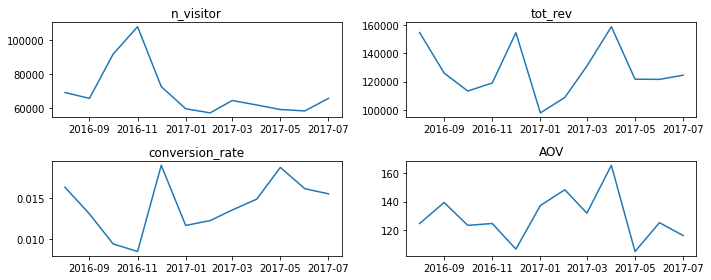

In [353]:
# visualization
fig, axs = plt.subplots(2, 2,figsize=(10,4))
axs[0, 0].plot(agg_month['timestamp'],agg_month['n_visitor'])
axs[0, 0].set_title('n_visitor')
axs[0, 1].plot(agg_month['timestamp'],agg_month['tot_rev'])
axs[0, 1].set_title('tot_rev')
axs[1, 0].plot(agg_month['timestamp'],agg_month['conversion_rate'])
axs[1, 0].set_title('conversion_rate')
axs[1, 1].plot(agg_month['timestamp'],agg_month['AOV'])
axs[1, 1].set_title('AOV')
fig.tight_layout() 

In [837]:
# include the newVisits column
query_= """
SELECT date,fullVisitorId,totals.transactionRevenue, totals.newVisits
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
"""
new_exist_df= client.query(query_).to_dataframe()
print(new_exist_df.shape)
new_exist_df.head(3)

(903653, 4)


,date,fullVisitorId,transactionRevenue,newVisits
0,20170516,9511832364821210514,NaN,1.0
1,20170516,4823353882333320348,NaN,1.0
2,20170516,0800568178159810103,NaN,1.0


In [875]:
ne_df=new_exist_df.copy()
ne_df['month']=pd.to_datetime(new_exist_df['date']).dt.to_period('M')
ne_df.newVisits.fillna(0, inplace = True)
ne_df['new_exist']=ne_df.newVisits.map({0:'existing',1:'new'})
ne_df.transactionRevenue.fillna(0, inplace = True) 
ne_df['new_exist'].value_counts()
ne_rev_df=pd.DataFrame(ne_df.groupby(['month','new_exist'])['transactionRevenue'].sum()/1000000).reset_index()
ne_rev_df

,month,new_exist,transactionRevenue
0,2016-08,existing,112822.72
1,2016-08,new,41843.84
2,2016-09,existing,98904.32
3,2016-09,new,27126.92
4,2016-10,existing,72819.81
5,2016-10,new,40509.26
6,2016-11,existing,90619.95
7,2016-11,new,28393.92
8,2016-12,existing,120404.43
9,2016-12,new,34153.50


In [894]:
ne_rev_df2=pd.DataFrame()
ne_rev_df2['exist']=ne_rev_df[ne_rev_df['new_exist']=='existing']['transactionRevenue'].values
ne_rev_df2['new']=ne_rev_df[ne_rev_df['new_exist']=='new']['transactionRevenue'].values

ne_rev_df2['ratio']=ne_rev_df2['exist']/ne_rev_df2['new']
ne_rev_df2.iloc[:-1,-1].mean()

3.0975445633457457

# Customer segmentation: 
RFM + k-means clustering -> interpret the centroid of that cluster.

### Extract the purchasers

In [33]:
#Exploring the data
#Feature- totals.transactions: Total number of ecommerce transactions within the session.
query_= """
SELECT totals.transactions,totals.transactionRevenue,* 
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE totals.transactions>0
  """
summary_df= client.query(query_).to_dataframe()
print(summary_df.shape)
summary_df.head(3)

(11552, 18)


,transactions,transactionRevenue,visitorId,visitNumber,visitId,visitStartTime,date,totals,trafficSource,device,geoNetwork,customDimensions,hits,fullVisitorId,userId,clientId,channelGrouping,socialEngagementType
0,1,1.114910e+09,NaN,1,1480471352,1480471352,20161129,"{'visits': 1, 'hits': 64, 'pageviews': 47, 'ti...","{'referralPath': '/', 'campaign': '(not set)',...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 18, 'minu...",1433472344011352817,None,None,Referral,Not Socially Engaged
1,1,5.114000e+07,NaN,4,1480456237,1480456237,20161129,"{'visits': 1, 'hits': 66, 'pageviews': 49, 'ti...","{'referralPath': '/', 'campaign': '(not set)',...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 13, 'minu...",2893040356372252170,None,None,Referral,Not Socially Engaged
2,1,1.239300e+08,NaN,1,1480434809,1480434809,20161129,"{'visits': 1, 'hits': 72, 'pageviews': 54, 'ti...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 7, 'minut...",5742668181891576634,None,None,Display,Not Socially Engaged


In [258]:
# Feature - 'fullVisitorId': The unique visitor ID (also known as client ID).
# Feature - 'totals.totalTransactionRevenue': Total transaction revenue, expressed as the value passed to Analytics multiplied by 10^6 (e.g., 2.40 would be given as 2400000).
purchaser_data=pd.DataFrame()
purchaser_data['date']=pd.to_datetime(summary_df['date'])
purchaser_data['user_id']=summary_df['fullVisitorId']
purchaser_data['amount']=summary_df['transactionRevenue']/1000000
purchaser_data.head(3)

,date,user_id,amount
0,2016-11-29,1433472344011352817,1114.91
1,2016-11-29,2893040356372252170,51.14
2,2016-11-29,5742668181891576634,123.93


### Calculate recency, frequency and monetary value for each users

In [103]:
purchaser_data.groupby('user_id')['date'].max().values[0]

numpy.datetime64('2017-04-28T00:00:00.000000000')

In [676]:
pur_df=pd.DataFrame()
pur_df['user_id']=purchaser_data.groupby('user_id')['date'].max().keys()

temp=pd.DataFrame(purchaser_data['date'].max()-purchaser_data.groupby('user_id')['date'].max())
temp['str_date']=temp['date'].apply(lambda x:int(str(x).split(' ')[0]))

pur_df['R']=temp['str_date'].values# most recent date
pur_df['F']=purchaser_data.groupby('user_id')['date'].count().values
pur_df['M']=purchaser_data.groupby('user_id').amount.sum().values
print(pur_df.shape)
pur_df.head(3)

(10022, 12)


,user_id,R,F,M,std_R,std_F,std_M,segment,std_M_quantile,M_quantile,segment_v1,segment_v2
0,0000213131142648941,95,1,33.59,-0.79,-0.21,-0.13,0,-0.48,0.361205,0,4
1,0002871498069867123,343,1,96.35,1.50,-0.21,-0.06,1,0.75,0.716574,1,2
2,0003450834640354121,287,1,57.95,0.98,-0.21,-0.11,1,0.21,0.559369,1,2


### Standardize & K-means clustering

In [230]:
# version 1
pur_df['std_R']=round((pur_df['R']-pur_df['R'].mean())/pur_df['R'].std(),2)
pur_df['std_F']=round((pur_df['F']-pur_df['F'].mean())/pur_df['F'].std(),2)
pur_df['std_M']=round((pur_df['M']-pur_df['M'].mean())/pur_df['M'].std(),2)
pur_df.head(3)

,user_id,R,F,M,std_R,std_F,std_M
0,0000213131142648941,95,1,33.59,-0.79,-0.21,-0.13
1,0002871498069867123,343,1,96.35,1.50,-0.21,-0.06
2,0003450834640354121,287,1,57.95,0.98,-0.21,-0.11


In [253]:
from sklearn.cluster import KMeans
X=pur_df.loc[:,['std_R','std_F','std_M']].values
kmeans = KMeans(n_clusters=5, random_state=0).fit(X)
print(kmeans.labels_)
print(pd.Series(kmeans.labels_).value_counts())
# print(kmeans.cluster_centers_)
center_ls=[]
for ls in kmeans.cluster_centers_: 
    center_ls.append([round(n,2)for n in ls])
print(center_ls)
pur_df['segment_v1']=kmeans.labels_

[0 1 1 ... 1 1 1]
1    5035
0    4719
4     251
2      16
3       1
dtype: int64
[[-0.9, -0.1, -0.05], [0.86, -0.12, -0.04], [-0.82, 15.05, 6.01], [-1.37, 20.72, 85.3], [-0.25, 3.32, 1.03]]


```noted that the smaller R is, the higher the frequency```
- Segment_0 (n=4719): high Recency, medium Frequency, medium Monetary value.
- Segment_1 (n=5035): low Recency, medium Frequency, medium Monetary value.
- Segment_2 (n=16): high Recency, high Frequency, high Monetary value.
- Segment_3 (n=1): high Recency, high Frequency, high Monetary value. (outliers)
- Segment_4 (n=251): medium Recency, high Frequency, medium Monetary value.

In [257]:
# version 2 - Monetary Value => quartile before standardize
from scipy import stats
pur_df['M_quantile']=stats.rankdata(pur_df['M'], "average")/len(pur_df['M'])
pur_df['std_M_quantile']=round((pur_df['M_quantile']-pur_df['M_quantile'].mean())/pur_df['M_quantile'].std(),2)
from sklearn.cluster import KMeans
X=pur_df.loc[:,['std_R','std_F','std_M_quantile']].values
kmeans = KMeans(n_clusters=5, random_state=0).fit(X)
print(kmeans.labels_)
print(pd.Series(kmeans.labels_).value_counts())
# print(kmeans.cluster_centers_)
center_ls=[]
for ls in kmeans.cluster_centers_: 
    center_ls.append([round(n,2)for n in ls])
print(center_ls)
pur_df['segment_v2']=kmeans.labels_

[4 2 2 ... 0 2 2]
2    2558
0    2541
4    2494
1    2330
3      99
dtype: int64
[[0.81, -0.19, -0.87], [-0.87, 0.12, 0.88], [0.91, 0.01, 0.84], [-0.46, 6.88, 1.55], [-0.93, -0.19, -0.85]]


```noted that the smaller R is, the higher the frequency```
- Segment_0 (n=2541): low Recency, medium Frequency, low Monetary value.   -> inactive low-value customer
- Segment_1 (n=2330): high Recency, medium Frequency, high Monetary value. -> active high-value customer
- Segment_2 (n=2558): low Recency, medium Frequency, high Monetary value.  -> inactive high-value customer
- Segment_3 (n=99): medium Recency, super high Frequency, super high Monetary value.   -> super stars
- Segment_4 (n=2494): high Recency, medium Frequency, low Monetary value.  -> active low-value customer

In [255]:
pur_df.to_csv('segmentation.csv')
pur_df.head(3)

,user_id,R,F,M,std_R,std_F,std_M,segment,std_M_quantile,M_quantile,segment_v1,segment_v2
0,0000213131142648941,95,1,33.59,-0.79,-0.21,-0.13,0,-0.48,0.361205,0,4
1,0002871498069867123,343,1,96.35,1.50,-0.21,-0.06,1,0.75,0.716574,1,2
2,0003450834640354121,287,1,57.95,0.98,-0.21,-0.11,1,0.21,0.559369,1,2


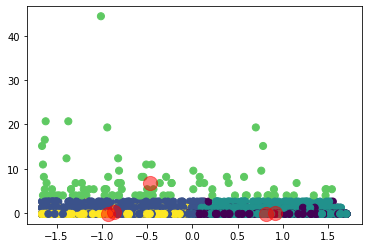

In [247]:
plt.scatter(X[:, 0], X[:, 1],c=kmeans.labels_,s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5);

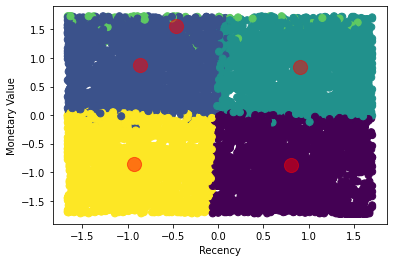

In [765]:
plt.scatter(X[:, 0], X[:, 2],c=kmeans.labels_,s=50, cmap='viridis')
plt.xlabel('Recency')
plt.ylabel('Monetary Value')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 2], c='red', s=200, alpha=0.5);

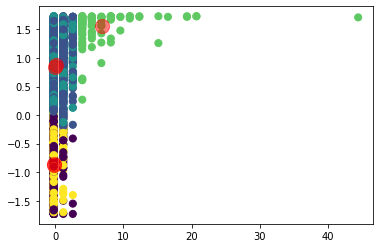

In [249]:
plt.scatter(X[:, 1], X[:, 2],c=kmeans.labels_,s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 1], centers[:, 2], c='red', s=200, alpha=0.5);

In [188]:
# https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html

# from sklearn.cluster import SpectralClustering
# model = SpectralClustering(n_clusters=5, affinity='nearest_neighbors',
#                            assign_labels='kmeans')
# labels = model.fit_predict(X)
# # plt.scatter(X[:, 0], X[:, 1], c=labels,
# #             s=50, cmap='viridis');
# print(model.labels_)
# print(pd.Series(model.labels_).value_counts())

[1 4 2 ... 2 4 2]
1    2947
2    2660
4    1753
0    1670
3     992
dtype: int64


# Cohort Analysis
The repeat % is one of the most important metrics brands focus on, and is closely related to churn rate.

Below I report the number of first-time customers from each monthly cohort. When those first-timers make additional purchases in the following months, I calculate the "Repeat %" as simply:

```Repeat % = Repeat Customers / Customers```

* noted that here each time I see a record in a certain month, I count it toward the cohort of that month regardless if it's the first visit or not. I do this so the sample size would be bigger and more robust to look at. I also generate the table when we take the first time visit factor into account.

In [797]:
cohort_data=purchaser_data.sort_values(by='date')
cohort_data['month']=cohort_data['date'].dt.to_period('M')
df_repurchase=pd.DataFrame(index=month_ls)
for n_mon in range(len(month_ls)):
    month = month_ls[n_mon]
    ori_user_id_set=set(cohort_data[cohort_data['month']==month]['user_id'])
    accum_repurchase_rate=0
    mov_mon=n_mon+1
    while mov_mon <len(month_ls):
        month = month_ls[mov_mon]
        later_user_id_set=set(cohort_data[cohort_data['month']==month]['user_id'])
        n_repurchase=len(ori_user_id_set.intersection(later_user_id_set))
        repurchase_rate=round(n_repurchase/len(ori_user_id_set),3)
        accum_repurchase_rate+=repurchase_rate
        df_repurchase.loc[month_ls[n_mon],month_ls[mov_mon]]=accum_repurchase_rate
        mov_mon+=1
df_repurchase['unique purchasers']=cohort_data.groupby('month')['user_id'].nunique()
df_repurchase['repeat purchasers']=df_repurchase['unique purchasers']*df_repurchase.iloc[:,11]
df_repurchase['repeat%']=(df_repurchase.iloc[:,11]*100).apply(lambda x:str(round(x,3))+'%')
df_repurchase

,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,unique purchasers,repeat purchasers,repeat%
2016-08,0.044,0.064,0.076,0.087,0.092,0.095,0.098,0.098,0.100,0.101,0.101,0.101,1046,105.646,10.1%
2016-09,NaN,0.043,0.062,0.073,0.079,0.079,0.083,0.086,0.086,0.087,0.087,0.087,793,68.991,8.7%
2016-10,NaN,NaN,0.059,0.098,0.122,0.142,0.160,0.173,0.183,0.188,0.190,0.190,818,155.420,19.0%
2016-11,NaN,NaN,NaN,0.060,0.101,0.120,0.145,0.159,0.175,0.178,0.185,0.186,864,160.704,18.6%
2016-12,NaN,NaN,NaN,NaN,0.033,0.056,0.077,0.085,0.097,0.101,0.106,0.107,1318,141.026,10.7%
2017-01,NaN,NaN,NaN,NaN,NaN,0.044,0.088,0.106,0.127,0.133,0.139,0.141,662,93.342,14.1%
2017-02,NaN,NaN,NaN,NaN,NaN,NaN,0.068,0.110,0.143,0.154,0.168,0.170,666,113.220,17.0%
2017-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.063,0.094,0.115,0.127,0.128,809,103.552,12.8%
2017-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.062,0.083,0.093,0.094,870,81.780,9.4%
2017-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.038,0.064,0.066,1055,69.630,6.6%


If the take the totals.newVisits condition into account, the repeat purchase rate will be as follows:

In [802]:
# query_= """
# SELECT date,fullVisitorId,totals.transactionRevenue,totals.newVisits
# FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
# WHERE totals.transactions>0 
#   """
# cohort_df= client.query(query_).to_dataframe()
# print(cohort_df.shape)
# # cohort_df.head(3)

# cohort_df['date']=pd.to_datetime(cohort_df['date'])
# cohort_data=cohort_df.sort_values(by='date')
# cohort_data['month']=cohort_data['date'].dt.to_period('M')
# df_repurchase=pd.DataFrame(index=month_ls)
# for n_mon in range(len(month_ls)):
#     month = month_ls[n_mon]
#     ori_user_id_set=set(cohort_data.loc[(cohort_data['month']=='2016-08') & (cohort_data['newVisits']==1),'fullVisitorId'])
#     accum_repurchase_rate=0
#     mov_mon=n_mon+1
#     while mov_mon <len(month_ls):
#         month = month_ls[mov_mon]
#         later_user_id_set=set(cohort_data[cohort_data['month']==month]['fullVisitorId'])
#         n_repurchase=len(ori_user_id_set.intersection(later_user_id_set))
#         repurchase_rate=round(n_repurchase/len(ori_user_id_set),3)
#         accum_repurchase_rate+=repurchase_rate
#         df_repurchase.loc[month_ls[n_mon],month_ls[mov_mon]]=accum_repurchase_rate
#         mov_mon+=1
# df_repurchase['unique purchasers']=cohort_data.groupby('month')['fullVisitorId'].nunique()
# df_repurchase['repeat purchasers']=df_repurchase['unique purchasers']*df_repurchase.iloc[:,11]
# df_repurchase['repeat%']=(df_repurchase.iloc[:,11]*100).apply(lambda x:str(round(x,3))+'%')
# df_repurchase

,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,unique purchasers,repeat purchasers,repeat%
2016-08,0.034,0.041,0.043,0.050,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,1046,54.392,5.2%
2016-09,NaN,0.007,0.009,0.016,0.018,0.018,0.018,0.018,0.018,0.018,0.018,0.018,793,14.274,1.8%
2016-10,NaN,NaN,0.002,0.009,0.011,0.011,0.011,0.011,0.011,0.011,0.011,0.011,818,8.998,1.1%
2016-11,NaN,NaN,NaN,0.007,0.009,0.009,0.009,0.009,0.009,0.009,0.009,0.009,864,7.776,0.9%
2016-12,NaN,NaN,NaN,NaN,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,1318,2.636,0.2%
2017-01,NaN,NaN,NaN,NaN,NaN,0.000,0.000,0.000,0.000,0.000,0.000,0.000,662,0.000,0.0%
2017-02,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.000,0.000,0.000,0.000,0.000,666,0.000,0.0%
2017-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.000,0.000,0.000,0.000,809,0.000,0.0%
2017-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.000,0.000,0.000,870,0.000,0.0%
2017-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.000,0.000,1055,0.000,0.0%


# CLV calculation: 
Prioritize High CLV(Customer livetime value) user

In [354]:
#Exploring the data
query_= """
SELECT * 
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170801`
  """
df= client.query(query_).to_dataframe()
print(df.shape)
df.head(3)

(2556, 16)


,visitorId,visitNumber,visitId,visitStartTime,date,totals,trafficSource,device,geoNetwork,customDimensions,hits,fullVisitorId,userId,clientId,channelGrouping,socialEngagementType
0,NaN,1,1501583974,1501583974,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Car...",[],"[{'hitNumber': 1, 'time': 0, 'hour': 3, 'minut...",2248281639583218707,None,None,Organic Search,Not Socially Engaged
1,NaN,1,1501616585,1501616585,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 12, 'minu...",8647436381089107732,None,None,Organic Search,Not Socially Engaged
2,NaN,1,1501583344,1501583344,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Asia', 'subContinent': 'Souther...","[{'index': 4, 'value': 'APAC'}]","[{'hitNumber': 1, 'time': 0, 'hour': 3, 'minut...",2055839700856389632,None,None,Organic Search,Not Socially Engaged


### Unnest columns
the ```hits column``` is skipped here for simplicity. However, in the real world setting, it's encouraged to work with marketers or field experts to include those variables.

In [357]:
# unnest totals column
query_= """
select * from unnest(array(
SELECT totals
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE _TABLE_SUFFIX BETWEEN '20160801' AND '20160831')
                    )
  """
totals_df= client.query(query_).to_dataframe()
# unnest trafficSource column
query_= """
select * from unnest(array(
SELECT trafficSource
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE _TABLE_SUFFIX BETWEEN '20160801' AND '20160831')
                    )
  """
trafficSource_df= client.query(query_).to_dataframe()
# unnest device column
query_ = """
select * from unnest(array(
SELECT device
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE _TABLE_SUFFIX BETWEEN '20160801' AND '20160831')
                    )
  """
device_df= client.query(query_).to_dataframe()
# unnest geoNetwork column
query_ = """
select * from unnest(array(
SELECT geoNetwork
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE _TABLE_SUFFIX BETWEEN '20160801' AND '20160831')
                    )
  """
geoNetwork_df= client.query(query_).to_dataframe()




In [429]:
query_ = """
select date,fullVisitorId,channelGrouping,socialEngagementType
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE _TABLE_SUFFIX BETWEEN '20160801' AND '20160831'
 """
df_201608= client.query(query_).to_dataframe()
df_201608=pd.concat([df_201608,totals_df,trafficSource_df,device_df,geoNetwork_df],axis=1)
df_201608['date']=pd.to_datetime(df_201608['date'])
df_201608=df_201608.sort_values(by='date')
df_201608.head(3)

,date,fullVisitorId,channelGrouping,socialEngagementType,visits,hits,pageviews,timeOnSite,bounces,transactions,transactionRevenue,newVisits,screenviews,uniqueScreenviews,timeOnScreen,totalTransactionRevenue,sessionQualityDim,referralPath,campaign,source,medium,keyword,adContent,adwordsClickInfo,isTrueDirect,campaignCode,browser,browserVersion,browserSize,operatingSystem,operatingSystemVersion,isMobile,mobileDeviceBranding,mobileDeviceModel,mobileInputSelector,mobileDeviceInfo,mobileDeviceMarketingName,flashVersion,javaEnabled,language,screenColors,screenResolution,deviceCategory,continent,subContinent,country,region,metro,city,cityId,networkDomain,latitude,longitude,networkLocation
44801,2016-08-01,76744637389790896,Referral,Not Socially Engaged,1,12,12.0,503.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,/yt/about/de/,(not set),youtube.com,referral,None,None,"{'campaignId': None, 'adGroupId': None, 'creat...",None,None,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,None,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Americas,Northern America,United States,New York,New York NY,New York,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,not available in demo dataset
30686,2016-08-01,0442105167270544631,Social,Not Socially Engaged,1,24,17.0,305.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,None,(not set),google,organic,(not provided),None,"{'campaignId': None, 'adGroupId': None, 'creat...",True,None,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,None,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Europe,Eastern Europe,Romania,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,bensoft.ro,not available in demo dataset,not available in demo dataset,not available in demo dataset
30685,2016-08-01,858006202985700318,Social,Not Socially Engaged,1,24,18.0,842.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/,(not set),(direct),(none),None,None,"{'campaignId': None, 'adGroupId': None, 'creat...",None,None,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,None,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Europe,Eastern Europe,Romania,Bucharest,(not set),Bucharest,not available in demo dataset,rdsnet.ro,not available in demo dataset,not available in demo dataset,not available in demo dataset


In [670]:
df_201608['newVisits'].value_counts()

1.0    58279
Name: newVisits, dtype: int64

### Clean the categorical variables & transform them into dummy forms.

In [572]:
useless_col=['transactionRevenue','screenviews','uniqueScreenviews','timeOnScreen','sessionQualityDim','campaignCode','browserVersion','browserSize','operatingSystemVersion','mobileDeviceBranding','mobileDeviceModel','mobileInputSelector','mobileDeviceInfo','mobileDeviceMarketingName','flashVersion','javaEnabled','language','screenColors','screenResolution','cityId','socialEngagementType','isMobile']
complex_col=['referralPath','keyword','adwordsClickInfo','metro','city','networkDomain','latitude','longitude','networkLocation','adContent','continent','campaign']
clean_col = ['country','region','source','browser','operatingSystem']   
########################################################
df_201608['country_v2']=df_201608['country'].map({'United States':'United States','Turkey':'Turkey','India':'India', 'United Kingdom':'United Kingdom', 'Canada':'Canada', 'Japan':'Japan',
       'Philippines':'Philippines', 'Brazil':'Brazil', 'Mexico':'Mexico', 'Germany':'Germany', 'Vietnam':'Vietnam', 'Russia':'Russia', 'Thailand': 'Thailand', 'Italy':'Italy', 'Australia':'Australia'})
df_201608['region_v2']=df_201608['region'].map({'California':'California','New York':'New York','Istanbul':'Istanbul', 'England':'England'})
df_201608['source_v2']=df_201608['source'].map({'google':'google','youtube.com':'youtube', '(direct)':'direct', 'Partners':'Partners', 'analytics.google.com':'analytics.google.com',
       'dfa':'dfa', 'sites.google.com':'sites.google.com', 'google.com':'google.com', 'baidu':'baidu', 'facebook.com':'facebook.com'})
df_201608['browser_v2']=df_201608['browser'].map({'Chrome':'Chrome', 'Safari':'Safari', 'Firefox':'Firefox', 'Internet Explorer':'Internet Explorer'})
df_201608['operatingSystem_v2']=df_201608['operatingSystem'].map({'Windows':'Windows', 'Macintosh':'Macintosh', 'Android':'Android', 'iOS':'iOS', 'Linux':'Linux', 'Chrome OS':'Chrome OS'})
########################################################
cat_col=[ 'channelGrouping', 'medium','isTrueDirect','deviceCategory', 'subContinent', 'country_v2',
       'region_v2','source_v2','browser_v2','operatingSystem_v2']
num_col=['visits', 'hits', 'pageviews', 'timeOnSite', 'bounces', 'transactions',
       'newVisits', 'totalTransactionRevenue']
########################################################


In [664]:
df_201608_clean=df_201608.drop(useless_col,axis=1).drop(complex_col,axis=1)
df_201608_clean[num_col] = df_201608_clean[num_col].fillna(0)
df_201608_dum=pd.get_dummies(df_201608_clean[cat_col], dummy_na=False) # dummy_na=False because we can drop one col of each category
df_201608_clean.head(2)

,date,fullVisitorId,channelGrouping,visits,hits,pageviews,timeOnSite,bounces,transactions,newVisits,totalTransactionRevenue,source,medium,isTrueDirect,browser,operatingSystem,deviceCategory,subContinent,country,region,country_v2,region_v2,source_v2,browser_v2,operatingSystem_v2
44801,2016-08-01,76744637389790896,Referral,1,12,12.0,503.0,0.0,0.0,1.0,0.0,youtube.com,referral,None,Chrome,Windows,desktop,Northern America,United States,New York,United States,New York,youtube,Chrome,Windows
30686,2016-08-01,0442105167270544631,Social,1,24,17.0,305.0,0.0,0.0,1.0,0.0,google,organic,True,Chrome,Windows,desktop,Eastern Europe,Romania,not available in demo dataset,NaN,NaN,google,Chrome,Windows


### This is the cleaned table with original fields for Tableau visualization

In [668]:
uu_201608_nodum=df_201608_clean.groupby('fullVisitorId').first()
uu_ls=uu_201608_nodum.index
CLV_201608=summary_df[summary_df['fullVisitorId'].isin(uu_ls)]
CLV_201608=(CLV_201608.groupby('fullVisitorId').agg({'transactionRevenue': 'sum', 'transactions': 'sum'})).reset_index()
CLV_201608['transactionRevenue']=CLV_201608['transactionRevenue']/1000000
CLV_201608.rename(columns={"transactions": "one_year_transact"},inplace=True)
CLV_201608.head(1)
# .to_csv('CLV_tb_nodum.csv')
model_tb_nodum=uu_201608_nodum.merge(CLV_201608,left_on='fullVisitorId',right_on='fullVisitorId',how='left')
model_tb_nodum['transactionRevenue'] = model_tb_nodum['transactionRevenue'].fillna(0)
model_tb_nodum['one_year_transact']=model_tb_nodum['one_year_transact'].fillna(0)
model_tb_nodum['one_year_transact_binary']=np.where(model_tb_nodum['one_year_transact'] ==0, 0, 1)
model_tb_nodum.head(3)
model_tb_nodum.to_csv('CLV_tb_nodum.csv')

### This is the cleaned table with dummy variables for ML model building

In [649]:
df_201608_clean=df_201608_clean.drop(clean_col,axis=1)
df_201608_allfeat=pd.concat([df_201608_clean,df_201608_dum],axis=1).drop(cat_col,axis=1)
print(df_201608_allfeat.shape)
df_201608_allfeat.head(3)
uu_201608_allfeat=df_201608_allfeat.groupby('fullVisitorId').first()
model_tb=df_201608_allfeat.merge(CLV_201608,left_on='fullVisitorId',right_on='fullVisitorId',how='left')
model_tb['transactionRevenue'] = model_tb['transactionRevenue'].fillna(0)
model_tb['one_year_transact']=model_tb['one_year_transact'].fillna(0)
model_tb['one_year_transact_binary']=np.where(model_tb['one_year_transact'] ==0, 0, 1)
model_tb.to_csv('CLV_tb.csv')
model_tb.head(3)

,date,fullVisitorId,visits,hits,pageviews,timeOnSite,bounces,transactions,newVisits,totalTransactionRevenue,channelGrouping_(Other),channelGrouping_Affiliates,channelGrouping_Direct,channelGrouping_Display,channelGrouping_Organic Search,channelGrouping_Paid Search,channelGrouping_Referral,channelGrouping_Social,medium_(none),medium_(not set),medium_affiliate,medium_cpc,medium_cpm,medium_organic,medium_referral,isTrueDirect_True,deviceCategory_desktop,deviceCategory_mobile,deviceCategory_tablet,subContinent_(not set),subContinent_Australasia,subContinent_Caribbean,subContinent_Central America,subContinent_Central Asia,subContinent_Eastern Africa,subContinent_Eastern Asia,subContinent_Eastern Europe,subContinent_Melanesia,subContinent_Micronesian Region,subContinent_Middle Africa,subContinent_Northern Africa,subContinent_Northern America,subContinent_Northern Europe,subContinent_Polynesia,subContinent_South America,subContinent_Southeast Asia,subContinent_Southern Africa,subContinent_Southern Asia,subContinent_Southern Europe,subContinent_Western Africa,subContinent_Western Asia,subContinent_Western Europe,country_v2_Australia,country_v2_Brazil,country_v2_Canada,country_v2_Germany,country_v2_India,country_v2_Italy,country_v2_Japan,country_v2_Mexico,country_v2_Philippines,country_v2_Russia,country_v2_Thailand,country_v2_Turkey,country_v2_United Kingdom,country_v2_United States,country_v2_Vietnam,region_v2_California,region_v2_England,region_v2_Istanbul,region_v2_New York,source_v2_Partners,source_v2_analytics.google.com,source_v2_baidu,source_v2_dfa,source_v2_direct,source_v2_facebook.com,source_v2_google,source_v2_google.com,source_v2_sites.google.com,source_v2_youtube,browser_v2_Chrome,browser_v2_Firefox,browser_v2_Internet Explorer,browser_v2_Safari,operatingSystem_v2_Android,operatingSystem_v2_Chrome OS,operatingSystem_v2_Linux,operatingSystem_v2_Macintosh,operatingSystem_v2_Windows,operatingSystem_v2_iOS,transactionRevenue,one_year_transact,one_year_transact_binary
0,2016-08-01,76744637389790896,1,12,12.0,503.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0.0,0.0,0
1,2016-08-01,0442105167270544631,1,24,17.0,305.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0.0,0.0,0
2,2016-08-01,858006202985700318,1,24,18.0,842.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0.0,0.0,0


### Reference 
https://stackoverflow.com/questions/12414043/map-each-list-value-to-its-corresponding-percentile

https://cloud.google.com/blog/products/data-analytics/predictive-marketing-analytics-using-bigquery-ml-machine-learning-templates

https://help.tresl.co/en/articles/4472015-what-is-repeat-on-the-customer-cohort-page-how-is-it-defined

https://towardsdatascience.com/rfm-analysis-using-bigquery-ml-bfaa51b83086

https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html